# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [1]:
# Import necessary libraries
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Import passengers.csv and set it as a time-series object. Plot the TS
df = pd.read_csv('passengers.csv')

In [2]:
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


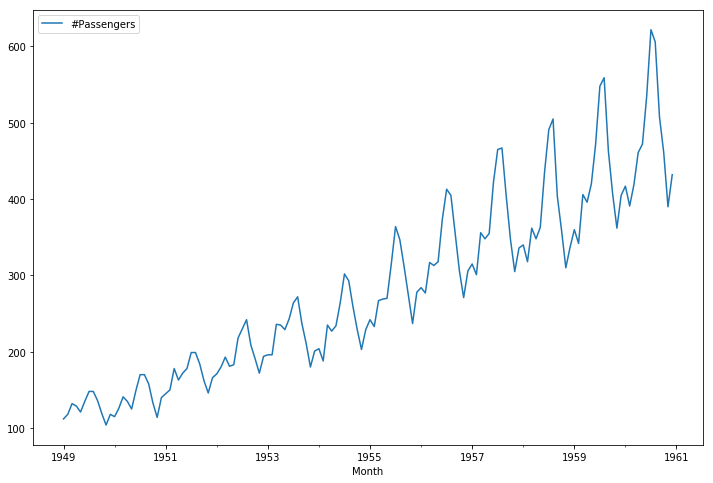

In [3]:
col_name = 'Month'
df[col_name] = pd.to_datetime(df[col_name])
df.set_index(col_name, inplace=True)
df.plot(figsize=(12,8))

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [4]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
ts = pd.Series(df['#Passengers'])

def stationary_checks(ts):
    # rolling stats
    rolmean = ts.rolling(window=6, center=False).mean()
    rolstd = ts.rolling(window=6, center=False).std()
    
    fig = plt.figure(figsize=(12,8))
    orig = plt.plot(ts, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    from statsmodels.tsa.stattools import adfuller
    
    dftest = adfuller(ts)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Num Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Use your newly created function on the airpassenger data set.

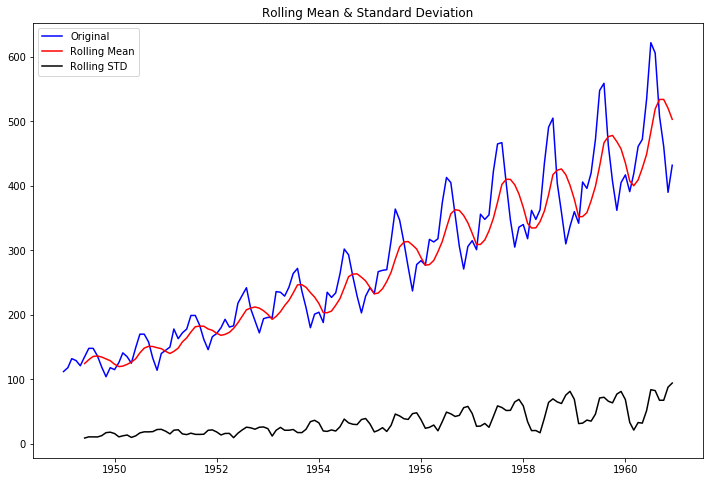

Test Statistic            0.815369
p-value                   0.991880
#Lags Used               13.000000
Num Obs                 130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [5]:
# Code here
ts = pd.Series(df['#Passengers'])
stationary_checks(ts)

## Perform a log() and sqrt() transform

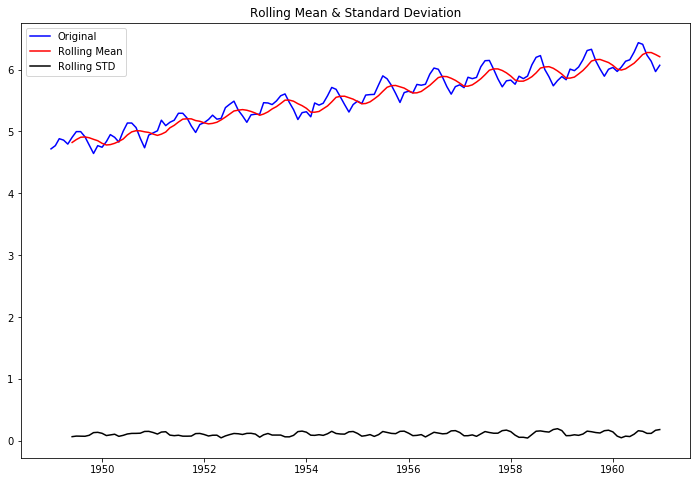

Test Statistic           -1.717017
p-value                   0.422367
#Lags Used               13.000000
Num Obs                 130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [10]:
# Log transform timeseries and compare with original to check the effect
import numpy as np

log_series = pd.Series(np.log(df['#Passengers']), index=df.index)
stationary_checks(log_series)

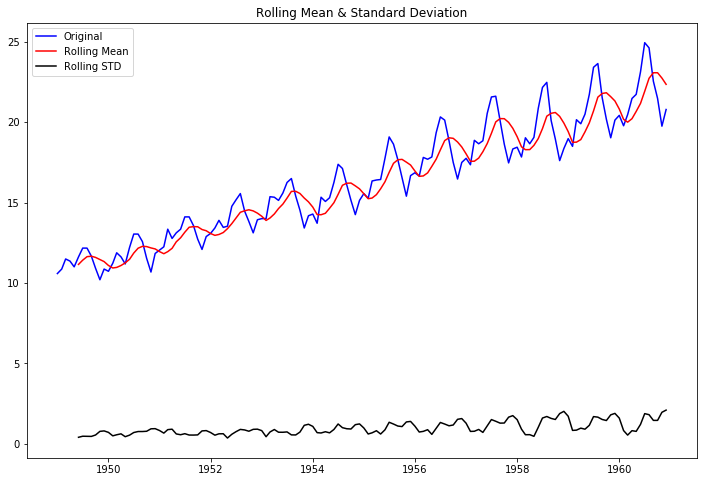

Test Statistic           -0.345854
p-value                   0.918754
#Lags Used               13.000000
Num Obs                 130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [9]:
sqrt_series = pd.Series(np.sqrt(df['#Passengers']), index=df.index)
stationary_checks(sqrt_series)

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

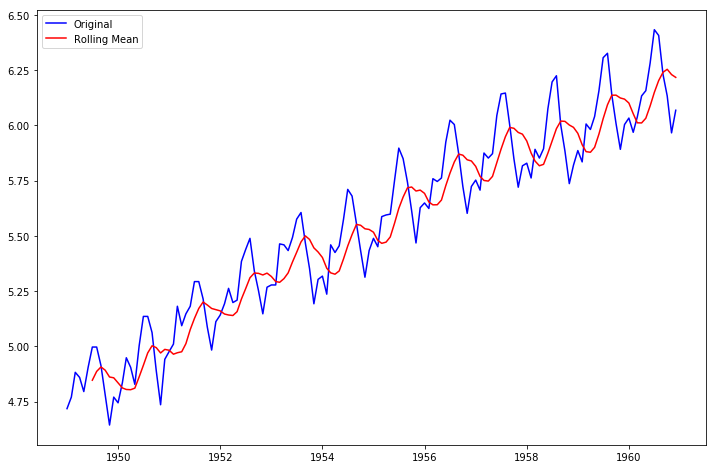

In [11]:
# your code here
rollingmean = log_series.rolling(window=7).mean()
fig = plt.figure(figsize=(12,8))
orig = plt.plot(log_series, color='blue', label='Original')
mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.show()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [12]:
# Subtract the moving average from the original data and check head for Nans
df_minus_rolmean = log_series - rollingmean
df_minus_rolmean.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.150059
1949-08-01    0.110242
1949-09-01    0.005404
1949-10-01   -0.113317
1949-11-01   -0.217275
1949-12-01   -0.087394
1950-01-01   -0.090241
1950-02-01    0.024099
1950-03-01    0.143499
Name: #Passengers, dtype: float64

In [13]:
# Drop the NaN values from timeseries calculated above
df_minus_rolmean.dropna(inplace=True)

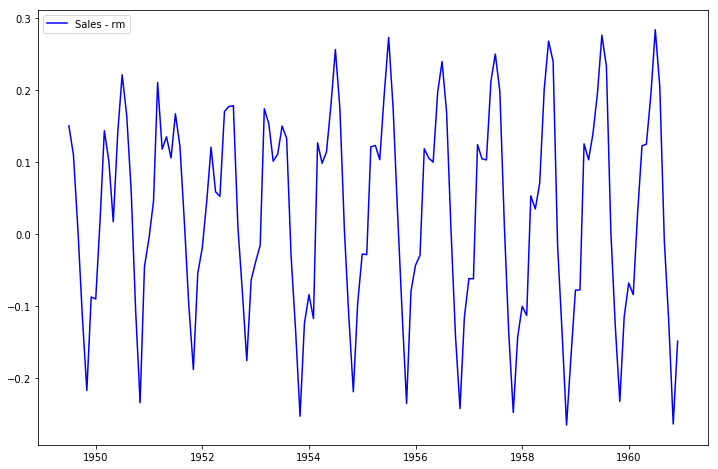

In [14]:
# Plot the result
fig = plt.figure(figsize=(12,8))
plt.plot(df_minus_rolmean, color='blue', label='Sales - rm')
plt.legend(loc='best')
plt.show()

Finally, use your function `check_stationarity` to see if this series is considered stationary!

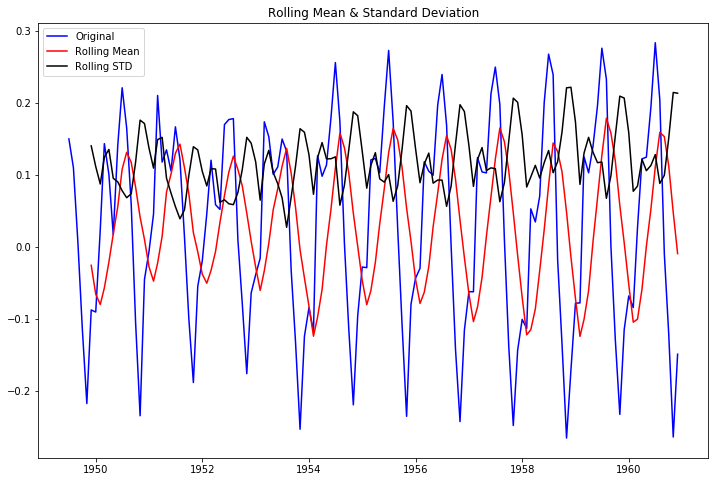

Test Statistic           -2.348027
p-value                   0.156946
#Lags Used               14.000000
Num Obs                 123.000000
Critical Value (1%)      -3.484667
Critical Value (5%)      -2.885340
Critical Value (10%)     -2.579463
dtype: float64


In [15]:
# Your code here
stationary_checks(df_minus_rolmean)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [16]:
# Your conclusion here
#slight trend of heteraskedasticity
#mean seems to stay relatively static
#not enough evidence to reject the null that they are not static

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

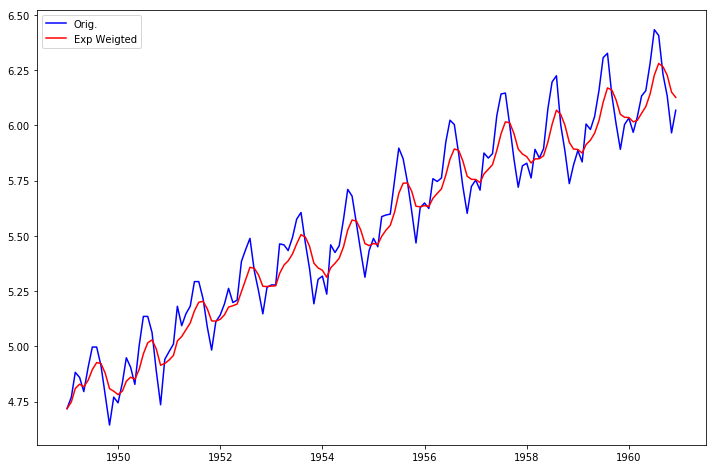

In [19]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = log_series.ewm(halflife=2).mean()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,8))
orig = plt.plot(log_series, c='b', label='Orig.')
mean = plt.plot(exp_rolmean, c = 'r', label='Exp Weigted')
plt.legend(loc='best')
plt.show();

In [20]:
# Subtract the moving average from the original data and plot
minus = log_series - exp_rolmean
minus.head()

Month
1949-01-01    0.000000
1949-02-01    0.021616
1949-03-01    0.073141
1949-04-01    0.030566
1949-05-01   -0.021553
Name: #Passengers, dtype: float64

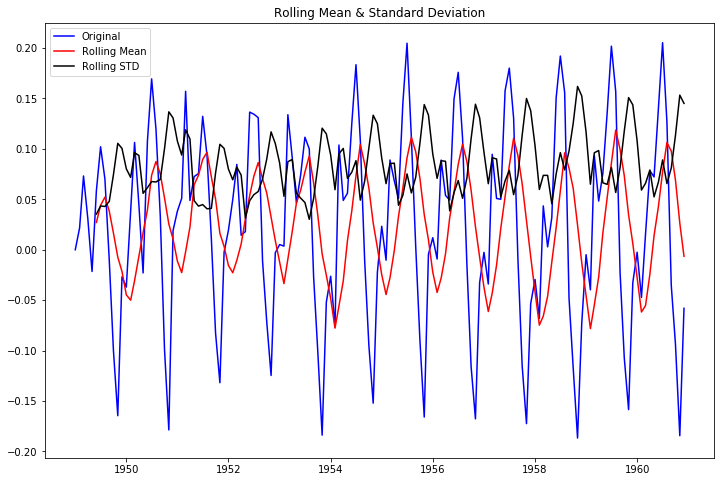

Test Statistic           -3.087696
p-value                   0.027477
#Lags Used               13.000000
Num Obs                 130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [21]:
# do a stationarity check
stationary_checks(minus)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?


In [22]:
# Your conclusion here
#this does give us enough evidence to state that the log transformed, exponentially weighted
#mean subtracted data is stationary

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [23]:
# difference your data and look at the head
data_diff = minus.diff(periods=6)
data_diff.head(10)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.102102
1949-08-01    0.048587
1949-09-01   -0.083097
1949-10-01   -0.130671
Name: #Passengers, dtype: float64

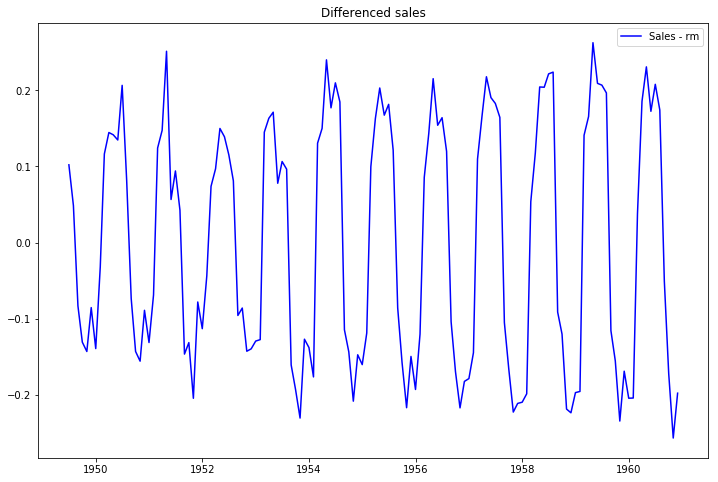

In [24]:
# plot your differenced time series
fig = plt.figure(figsize=(12,8))
plt.plot(data_diff, c='b', label='Sales - rm')
plt.legend(loc='best')
plt.title('Differenced sales')
plt.show();

In [25]:
# drop nas
data_diff.dropna(inplace=True)

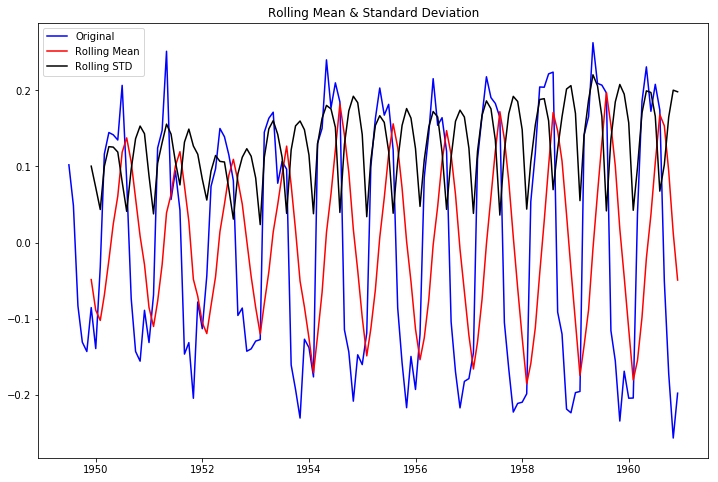

Test Statistic           -5.327806
p-value                   0.000005
#Lags Used                7.000000
Num Obs                 130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [26]:
# perform the stationarity check
stationary_checks(data_diff)

### Your conclusion

In [27]:
# Your conclusion here
#greater significance in the DF test suggests greater stationarity
#6 mo segments are less pointed, suggesting a tapering in their significance
#slightest of heteroskedasticity in the mean

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.